In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
from warnings import filterwarnings
from chainer import serializers
#print(check_output(["dir", "C:/Users/User/Documents/RL_"]).decode("utf8"))
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)  
# Any results you write to the current directory are saved as output.

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
D:\Anaconda\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
import time
import copy
import numpy as np
import array as arr
import pandas as pd
import chainer
import chainer.functions as F
import chainer.links as L
import matplotlib.pyplot as plt
from plotly.offline import plot
import datetime
import plotly.graph_objects as go
#from plotly import tools
#from plotly.graph_objs import *
#from plotly.offline import init_notebook_mode, iplot, iplot_mpl

In [3]:
data = pd.read_csv('C:/Users/User/Documents/RL_/Data/Stocks/SPY_Both.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2001-01-02 00:00:00 2019-12-30 00:00:00


,Open,High,Low,Close,Adj Close,Volume,Gold_Adj Close,WTI_Adj Close
Date,,,,,,,,
2001-01-02,1320.280029,1320.280029,1276.050049,1283.270020,1283.270020,1129400000,268.399994,27.200001
2001-01-03,1283.270020,1347.760010,1274.619995,1347.560059,1347.560059,1880700000,268.000000,27.950001
2001-01-04,1347.560059,1350.239990,1329.140015,1333.339966,1333.339966,2131000000,267.299988,28.200001
2001-01-05,1333.339966,1334.770020,1294.949951,1298.349976,1298.349976,1430800000,268.000000,28.000000
2001-01-08,1298.349976,1298.349976,1276.290039,1295.859985,1295.859985,1115500000,268.000000,27.350000


In [4]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2019, 12, 31)
total_days = (end_date - start_date).days
train_days = int(total_days * 0.9)
test_start_date = start_date + datetime.timedelta(days=train_days)
date_split = test_start_date.date()
train = data[:date_split]
test = data[date_split:]
print("訓練", start_date.date(), "到", test_start_date.date())
print("測試", test_start_date.date(), "到", end_date.date())

訓練 2010-01-01 到 2018-12-30
測試 2018-12-30 到 2019-12-31


In [5]:
def plot_train_test(train, test, date_split):
    # 创建图形
    train_candle = go.Candlestick(x=train.index, open=train['Open'], high=train['High'], low=train['Low'], close=train['Close'], name='Train')
    test_candle = go.Candlestick(x=test.index, open=test['Open'], high=test['High'], low=test['Low'], close=test['Close'], name='Test')
    
    fig = go.Figure(data=[train_candle, test_candle])
    
    # 添加分割线
    fig.add_shape(
        type="line",
        x0=date_split, y0=min(min(train['Low']), min(test['Low'])),
        x1=date_split, y1=max(max(train['High']), max(test['High'])),
        line=dict(color="Black", width=2)
    )
    
    # 添加注释
    fig.add_annotation(
        x=date_split, y=max(max(train['High']), max(test['High'])), ax=0, ay=-30,
        xref='x', yref='y',
        showarrow=True, arrowhead=1,
        text="Start of Test Data"
    )
    
    # 更新布局
    fig.update_layout(title='Train and Test Data Visualization', xaxis_title='Date', yaxis_title='Price')
    
    # 显示图形
    plot(fig)

# 调用函数
plot_train_test(train, test, date_split)

In [6]:
class Environment1:
    
    def __init__(self, data, history_t=90):
        self.data = data
        self.history_t = history_t
        self.reset()
        
    def reset(self):
        self.t = 0
        self.done = False
        self.profits = 10000 #初始資金
        self.count = []
        self.positions = []
        self.position_value = 0
        self.brok_rate=0.0009
        self.max_trade_percent = 0.8
        self.tbrokerage = 0
        self.history = [0 for _ in range(self.history_t)]
        self.Act0=0
        self.Act1=0
        self.Act2=0
        self.RW_p=0
        self.RW_n=0
        self.RW_p_v=0
        self.RW_n_v=0
        return [self.position_value] + self.history # obs
    
    def step(self, act):
        if self.t >= len(self.data) - 1:
            self.done = True
            return [self.position_value] + self.history, 0, self.done
        reward = 0
        #print(act)
        #print(amount)
        # act = 0: stay, 1: buy, 2: sell
        if act == 1:
            if self.profits != 0:
                max_trade_amount = self.profits*self.max_trade_percent
                stock_price = self.data.iloc[self.t, :]['Close']
                count = max_trade_amount / stock_price
                #self.tbrokerage = self.brok_rate*self.data.iloc[self.t, :]['Close']
                buyin = stock_price * count
                self.profits = self.profits - buyin 
                #print('\t'.join(map(str, ['buy',self.data.iloc[self.t, :]['Close'], amount, buyin, self.profits])))
                self.positions.append(stock_price)
                self.count.append(count)
                self.Act1+=1
                #print('\t'.join(map(str, ['buy', amount, buyin, self.profits])))
                
        elif act == 2: # sell
            if len(self.positions) > 0:
                num_positions_to_sell = int(len(self.positions))

                for i in range(num_positions_to_sell):
                    sell_price = self.data.iloc[self.t, :]['Close']
                    buy_price = self.positions[i]
                    count = self.count[i]
                    abs_num = (sell_price - buy_price) * count
                    if abs_num > 0: 
                        self.RW_p += 1 
                        self.RW_p_v += abs_num
                    else: 
                        self.RW_n += 1
                        self.RW_n_v += abs(abs_num)
                    reward += sell_price * count
                    self.profits += sell_price * count
                self.positions = self.positions[num_positions_to_sell:]
                self.count = self.count[num_positions_to_sell:]
                self.Act2 += 1    
        
        else :
            self.Act0+=1
        
        # set next time
        self.t += 1
        self.position_value = 0
        for p in self.positions:
            self.position_value += (self.data.iloc[self.t, :]['Close'] - p)
        self.history.pop(0)
        self.history.append(self.data.iloc[self.t, :]['Close'] - self.data.iloc[(self.t-1), :]['Close'])
        
        # clipping reward
        if reward > 0:
            reward = 1
        elif reward < 0:
            reward = -1
        
        return [self.position_value] + self.history, reward, self.done # obs, reward, done
    def determine_sell_ratio(self, signal_strength):
        # Example thresholds and ratios
        thresholds = [0.2, 0.5, 0.8]
        ratios = [0.25, 0.5, 0.75]

        for i, threshold in enumerate(thresholds):
            if signal_strength < threshold:
                return ratios[i]
        return ratios[0]  # Sell the largest ratio but not everything if the signal is very strong

In [7]:
env = Environment1(train)
print(env.reset())
for _ in range(3):
    pact = np.random.randint(3)
    amount = 0.333
    print(env.step(pact,amount))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


TypeError: step() takes 2 positional arguments but 3 were given

In [12]:
# DQN

def train_dqn(env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()

    Q = Q_Network(input_size=env.history_t+1, hidden_size=100, output_size=3)
    Q_ast = copy.deepcopy(Q)
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(Q)

    epoch_num = 50
    step_max = len(env.data)-1
    memory_size = 200
    batch_size = 20
    epsilon = 1.0
    epsilon_decrease = 1e-3
    epsilon_min = 0.1
    start_reduce_epsilon = 200
    train_freq = 10
    update_q_freq = 20
    gamma = 0.97
    show_log_freq = 1
    confidence_threshold_buy = 0.1
    confidence_threshold_sell = 0.8
    memory = []
    total_step = 0
    total_rewards = []
    total_losses = []
    start = time.time()

    print('\t'.join(map(str, ['epoch','profit','          ','buy','sell','hold'])))
    for epoch in range(epoch_num):

        pobs = env.reset()
        step = 0
        done = False
        total_reward = 0
        total_loss = 0
        RandAct = 0
        NRandAct = 0
        while not done and step < step_max:
            #if step==2264 :
            #    env.profits=10000
            #    env.count=0
                
            # select act
            pact = np.random.randint(3)
            if np.random.rand() > epsilon:
                pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
                pact = np.argmax(pact.data)

                NRandAct+=1
            else:
                RandAct+=1
            # act
            obs, reward, done = env.step(pact)

            # add memory
            memory.append((pobs, pact, reward, obs, done))
            if len(memory) > memory_size:
                memory.pop(0)

            # train or update q
            if len(memory) == memory_size:
                if total_step % train_freq == 0:
                    shuffled_memory = np.random.permutation(memory)
                    memory_idx = range(len(shuffled_memory))
                    for i in memory_idx[::batch_size]:
                        batch = np.array(shuffled_memory[i:i+batch_size])
                        b_pobs = np.array(batch[:, 0].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_pact = np.array(batch[:, 1].tolist(), dtype=np.int32)
                        b_reward = np.array(batch[:, 2].tolist(), dtype=np.int32)
                        b_obs = np.array(batch[:, 3].tolist(), dtype=np.float32).reshape(batch_size, -1)
                        b_done = np.array(batch[:, 4].tolist(), dtype=np.bool)

                        q = Q(b_pobs)
                        maxq = np.max(Q_ast(b_obs).data, axis=1)
                        target = copy.deepcopy(q.data)
                        for j in range(batch_size):
                            target[j, b_pact[j]] = b_reward[j]+gamma*maxq[j]*(not b_done[j])
                        Q.reset()
                        loss = F.mean_squared_error(q, target)
                        total_loss += loss.data
                        loss.backward()
                        optimizer.update()

                if total_step % update_q_freq == 0:
                    Q_ast = copy.deepcopy(Q)

            # epsilon
            if epsilon > epsilon_min and total_step > start_reduce_epsilon:
                epsilon -= epsilon_decrease

            # next step
            total_reward += reward
            pobs = obs
            step += 1
            total_step += 1

        total_rewards.append(total_reward)
        total_losses.append(total_loss)

        if (epoch+1) % show_log_freq == 0:
            log_reward = sum(total_rewards[((epoch+1)-show_log_freq):])/show_log_freq
            log_loss = sum(total_losses[((epoch+1)-show_log_freq):])/show_log_freq
            #log_profits = 0
            log_profits = env.profits
            if len(env.count) != 0:
                for i in range(0,len(env.positions)):
                    log_profits += env.count[i]*env.data.iloc[env.t, :]['Close']
            else :
                log_profits = env.profits
            elapsed_time = time.time()-start
            
            print('\t'.join(map(str, [epoch+1,log_profits])))
            #print('\t'.join(map(str, [epoch+1,env.RW_p,env.RW_n,env.RW_p_v,env.RW_n_v])))
            start = time.time()
    chainer.serializers.save_npz('Origin_DQN.npz', Q)        
    return Q, total_losses, total_rewards
    

In [13]:
Q, total_losses, total_rewards = train_dqn(Environment1(train))

epoch	profit	          	buy	sell	hold
1	13600.596831052684
2	10723.778773483587
3	13592.327128742703
4	11939.558840215963
5	8745.9330859576
6	10291.114297737464
7	12206.678502819013
8	28180.087385989318
9	13864.046391706202
10	12457.006326370853
11	15255.369667298643
12	6973.588518109705
13	14261.421816781713
14	10241.249612338044
15	9609.377819743117
16	10780.995284193985
17	9257.56679300602
18	13318.63283968125
19	10581.015943997485
20	11361.988183972393
21	14197.293098207578
22	14426.888470665717
23	21701.039995611358
24	21881.68509708227
25	9779.485533087522
26	11360.427434508209
27	14713.813511549866
28	12502.69105297812
29	12514.590716660741
30	8225.46820893664
31	10023.24193679725
32	15049.292973913798
33	12585.907110408523
34	8481.410307590282
35	15470.433254715694
36	7757.880678785057
37	19256.04309491263
38	14206.447433026173
39	12681.148630603042
40	8409.463014220197
41	13541.489456085215
42	14203.241061655186
43	10032.72345376804
44	15355.93106466518
45	12296.608385939575
4

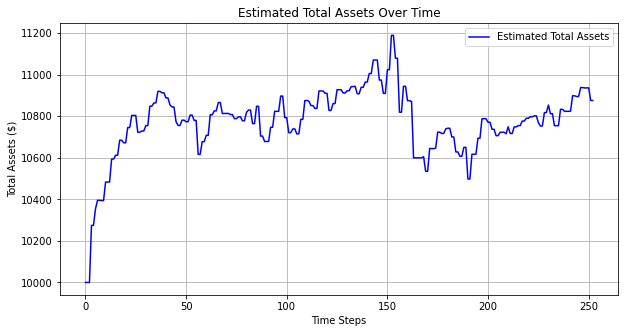

Final profits: 10875.563203273423


In [57]:
import matplotlib.pyplot as plt

def test_dqn(test_env, Q, confidence_threshold_buy=0.1, confidence_threshold_sell=0.8):
    # 重置环境
    pobs = test_env.reset()
    test_env.profits = 10000  # 重置初始资金
    test_acts = []
    test_rewards = []
    estimated_total_assets = [test_env.profits]  # 记录每步的总资产，初始资金为起始值
    epsilon=0.1

    while not test_env.done:
        # 使用DQN产生行动的概率分布
        pact = np.random.randint(3)
        if np.random.rand() > epsilon:
            pact = Q(np.array(pobs, dtype=np.float32).reshape(1, -1))
            pact = np.argmax(pact.data)
        
        # 根据设定的阈值判断是否执行买入或卖出

        
        # 执行行动
        obs, reward, done = test_env.step(pact)
        test_acts.append(pact)
        test_rewards.append(reward)
        pobs = obs

        # 估算总资产
        stock_value = sum(c * test_env.data.iloc[test_env.t]['Close'] for c in test_env.count)
        total_assets = test_env.profits + stock_value
        estimated_total_assets.append(total_assets)

    # 绘制估算总资产的折线图
    plt.figure(figsize=(10, 5))
    plt.plot(estimated_total_assets, label='Estimated Total Assets', color='blue')
    plt.title('Estimated Total Assets Over Time')
    plt.xlabel('Time Steps')
    plt.ylabel('Total Assets ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    final_profits = total_assets
    return test_acts, test_rewards, final_profits
def load_and_test_dqn(test_env):

    class Q_Network(chainer.Chain):

        def __init__(self, input_size, hidden_size, output_size):
            super(Q_Network, self).__init__(
                fc1 = L.Linear(input_size, hidden_size),
                fc2 = L.Linear(hidden_size, hidden_size),
                fc3 = L.Linear(hidden_size, output_size)
            )

        def __call__(self, x):
            h = F.relu(self.fc1(x))
            h = F.relu(self.fc2(h))
            y = self.fc3(h)
            return y

        def reset(self):
            self.zerograds()
    Q_loaded = Q_Network(input_size=test_env.history_t+1, hidden_size=100, output_size=3)
    chainer.serializers.load_npz('Origin_DQN.npz', Q_loaded)
    
    # 现在使用加载的模型来进行测试
    test_acts, test_rewards, test_profits = test_dqn(test_env, Q_loaded)
    #print("Test actions:", test_acts)
    #print("Test rewards:", test_rewards)
    print("Final profits:", test_profits)
# 调用函数进行测试
test_data = test  # 确保已正确设置测试数据
test_env = Environment1(data=test_data, history_t=90)
load_and_test_dqn(test_env)